This tutorial can be downloaded [link](http://greatfire.uchicago.edu/west-public/West/raw/master/Doc/tutorials/basic/basic_001.ipynb).

# Intro tutorial 1: Getting Started with full-frequency GW calculations

In order to compute the full-frequency $G_0W_0$ electronic structure of the silane molecule you need to run `pw.x`, `wstat.x` and `wfreq.x` in sequence. Documentation for building and installing WEST is available at this [link](http://www.west-code.org/doc/West/latest/installation.html).

The GW workflow involves three sequental steps:

- Step 1: Mean-field starting point
- Step 2: Calculation of dielectric screening
- Step 3: Calculation of quasiparticle corrections

Each step is explained below. At the end of step 3 you will be able to obtain the electronic structure of the silane molecule at the $G_0W_0 @ PBE$ level of theory, where the GW is computed without empty states and with full frequency integration using the countour deformation technique. For more information about the implementation, we refer to [Govoni et al., J. Chem. Theory Comput. 11, 2680 (2015)](https://doi.org/10.1021/ct500958p).

## Step 1: Mean-field starting point

The mean-field electronic structure of the silane molecule is obtained using density functional theory (DFT), as implemented in the [Quantum ESPRESSO](https://www.quantum-espresso.org/) code. This is obtained by running `pw.x`. Check the installation section of the documentation to understand which version of Quantum ESPRESSO is compatible with WEST. The ONCV pseudopotential files for **Si** and **H** in UPF format (obtained using the PBE exchange-correlation functional) can be downloaded from: [QE-PP](https://www.quantum-espresso.org/pseudopotentials) database, or from [SG15](http://www.quantum-simulation.org/potentials/sg15_oncv/upf/) database. Check out the `pw.x` [input description](https://www.quantum-espresso.org/Doc/INPUT_PW.html) in order to generate an input file for Quantum ESPRESSO called `pw.in`.

Download the following files in your current working directory:

In [1]:
%%bash
wget -N -q http://www.west-code.org/doc/training/silane/pw.in
wget -N -q http://www.quantum-simulation.org/potentials/sg15_oncv/upf/H_ONCV_PBE-1.2.upf
wget -N -q http://www.quantum-simulation.org/potentials/sg15_oncv/upf/Si_ONCV_PBE-1.2.upf

Let's inspect the ``pw.in`` file, input for ``pw.x``.

In [2]:
%%bash
cat pw.in

&control
calculation  = 'scf'
restart_mode = 'from_scratch'
pseudo_dir   = './'
outdir       = './'
prefix       = 'silane'
wf_collect   = .TRUE.
/
&system
ibrav           = 1
celldm(1)       = 20
nat             = 5
ntyp            = 2
ecutwfc         = 25.0
nbnd            = 10
assume_isolated ='mp'
/
&electrons
diago_full_acc = .TRUE.
/
ATOMIC_SPECIES
Si 28.0855  Si_ONCV_PBE-1.2.upf
H  1.00794   H_ONCV_PBE-1.2.upf
ATOMIC_POSITIONS bohr
Si      10.000000   10.000000  10.000000
H       11.614581   11.614581  11.614581
H        8.385418    8.385418  11.614581
H        8.385418   11.614581   8.385418
H       11.614581    8.385418   8.385418
K_POINTS {gamma}


For a molecule we sampled the Brillouin zone using the Gamma point only. For periodic systems you can use an automatic and centered k-points mesh. We have placed the molecule in a cubic cell with an edge of 20 a.u. (`celldm(1)`). The size of the basis set (how many Fourier components are used to describe single-particle wavefunctions) is specified by setting the variable `ecutwfc` to 25 Ry. All these parameters are system dependent and may need to be converged.

Run ``pw.x`` on 2 cores. The number of cores may be increased depending on the size of the system and the available computational resources.

In [ ]:
%%bash
mpirun -n 2 pw.x -i pw.in > pw.out

The output file ``pw.out`` contains information about the mean-field calculation.

## Step 2: Calculation of dielectric screening

The static dielectric screening is computed using the projective dielectric eigendecomposition (PDEP) technique. Check out the ``wstat.x`` [input description](http://www.west-code.org/doc/West/latest/) and generate an input file for WEST called ``wstat.in``.

Download this file in your current working directory:

In [3]:
%%bash
wget -N -q http://www.west-code.org/doc/training/silane/wstat.in

Let's inspect the ``wstat.in`` file, input for ``wstat.x``.

In [4]:
%%bash
cat wstat.in

input_west:
    qe_prefix: silane
    west_prefix: silane
    outdir: ./

wstat_control:
    wstat_calculation: S
    n_pdep_eigen: 50

In this input file we compute 50 PDEPs, i.e., 50 eigenvectors of the static dielectric matrix. This step uses the *occupied* single-particle states and energies obtained in the previous step (mean-field calculation). Note that **unoccupied states are not needed**.

Run ``wstat.x`` on 2 cores. The number of cores may be increased depending on the size of the system and the available computational resources. [Tutorial 4](http://greatfire.uchicago.edu/west-public/West/raw/master/Doc/tutorials/basic/basic_004.ipynb) explains additional flags that can be used to control the distribution of data-structures and loops. In this tutorial, we are not going to use any specific parallelization flag, which means that Fourier transform operations are distributed using the chosen number of cores (2).

In [ ]:
%%bash
mpirun -n 2 wstat.x -i wstat.in > wstat.out

The output file ``wstat.out`` contains information about the PDEP iterations. Dielectric eigenvalues can be found in the file ``<west_prefix>.wstat.save/wstat.json``. This file is machine readable (JSON format).

If the reader does NOT have the computational resources to run the calculation, the WEST output file needed for the next step can be directly downloaded as:

In [5]:
%%bash
mkdir -p silane.wstat.save
wget -N -q http://www.west-code.org/doc/training/silane/wstat.json -O silane.wstat.save/wstat.json

Below we show how to load, print, and plot the PDEP eigenvalues.

In [6]:
import json
import numpy as np

# Load the output data
with open('silane.wstat.save/wstat.json') as json_file :
    data = json.load(json_file)

# Extract converged PDEP eigenvalues
ev = np.array(data['exec']['davitr'][-1]['ev'],dtype='f8') # -1 identifies the last iteration

In [7]:
# Print
print(ev)

[-1.2746729  -1.19123668 -1.19114095 -1.19109545 -0.82404822 -0.82400394
 -0.82390314 -0.635782   -0.62934203 -0.6293231  -0.50049559 -0.50047539
 -0.50041874 -0.42991703 -0.42990245 -0.42988114 -0.23238097 -0.2323769
 -0.23236338 -0.18323023 -0.18320714 -0.18319987 -0.17839625 -0.17749216
 -0.1774905  -0.14592151 -0.1459186  -0.14590667 -0.12256418 -0.12011843
 -0.12011402 -0.12010991 -0.11634223 -0.11634118 -0.11528637 -0.11528175
 -0.11528151 -0.09407982 -0.09407648 -0.09407436 -0.07995305 -0.07994979
 -0.0799484  -0.07477637 -0.07309848 -0.07309674 -0.06577741 -0.06577163
 -0.06576642 -0.06313331]


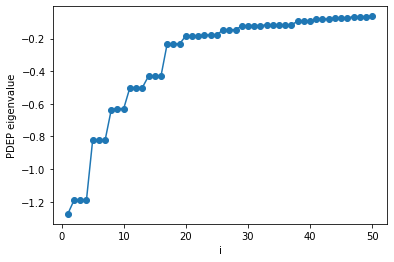

In [8]:
import matplotlib.pyplot as plt

# Create x-axis
iv = np.linspace(1,ev.size,ev.size,endpoint=True)

# Plot
plt.plot(iv,ev,'o-')
plt.xlabel('i')
plt.ylabel('PDEP eigenvalue')

plt.show()

As we can see the eigenvalues of the dielectric response decay to zero (see [J. Chem. Theory Comput. 11, 2680 (2015)](https://doi.org/10.1021/ct500958p), and references therein). The number of PDEPs is a parameter of the simulation that is system dependent and needs to be converged. Typically the number of PDEPs is set equal to multiple of the number of electrons.

## Step 3: Calculation of quasiparticle corrections

The GW electronic structure is computed treating the frequency integration of the correlation part of the self energy with the contour deformation techinique and by computing the dielectric screening at multipole frequencies with Lanczos iterations. Check out the ``wfreq.x`` [input description](http://www.west-code.org/doc/West/latest/) and generate an input file for WEST called ``wfreq.in``.

Download this file in your current working directory:

In [9]:
%%bash
wget -N -q http://www.west-code.org/doc/training/silane/wfreq.in

Let's inspect the ``wfreq.in`` file, input for ``wfreq.x``.

In [10]:
%%bash
cat wfreq.in

input_west:
    qe_prefix: silane
    west_prefix: silane
    outdir: ./

wstat_control:
    wstat_calculation: S
    n_pdep_eigen: 50

wfreq_control:
    wfreq_calculation: XWGQ
    n_pdep_eigen_to_use: 50
    qp_bandrange: [1,5]
    n_refreq: 300
    ecut_refreq: 2.0

We compute the quasiparticle corrections of states identified by band indexes $1,2,3,4,5$. We have set PDEPs to 50, this number can be reduced in order to check convergence. For the Contour Deformation technique, the frequency dependence of the dielectric screening is sampled in the energy window $[0,2]$Ry using 300 points.

According to perturbation theory, the quasiparticle energy $E_{kn}$ of the state with band index $n$ and k-point $k$ is computed as:

$E_{kn} = \varepsilon_{kn} + \Sigma^X_{kn} + \Sigma^C_{kn}(E_{kn}) - V^{xc}_{kn}$

where $\varepsilon_{kn}$ is the mean-field (or Kohn-Sham) single-particle energy (obtained in Step 1), $\Sigma^X_{kn}$, $\Sigma^C_{kn}(E_{kn})$, and $V^{xc}_{kn}$ are the contributions to the signle-particle energy given by the exchange self-energy, correlation self-energy and the exchange-correlation potential used in Step 1. Note that the correlation self-energy depends on the energy and hence this equation is solved using an iterative solver (e.g., the secant method), or by approximating the self-energy to first order in the frequency.

Run ``wfreq.x`` on 2 cores. As for ``wstat.x``, the number of cores may be increased depending on the size of the system and the available computational resources. [Tutorial 4](http://greatfire.uchicago.edu/west-public/West/raw/master/Doc/tutorials/basic/basic_004.ipynb) explains additional flags that can be used to control the distribution of data-structures and loops. In this tutorial, we are not going to use any specific parallelization flag, which means that Fourier transform operations are distributed using the chosen number of cores (2).

In [ ]:
%%bash
mpirun -n 2 wfreq.x -i wfreq.in > wfreq.out

The output file ``wfreq.out`` contains information about the calculation of the GW self-energy, and the corrected electronic structure can be found in the file ``<west_prefix>.wfreq.save/wfreq.json``.

If the reader does NOT have the computational resources to run the calculation, the WEST output file needed for the next step can be directly downloaded as:

In [11]:
%%bash
mkdir -p silane.wfreq.save
wget -N -q http://www.west-code.org/doc/training/silane/wfreq.json -O silane.wfreq.save/wfreq.json

Below we show how to load and print the quasiparticle corrections.

In [12]:
# Read the output of Wfreq: wfreq.json

def wfreq2df(filename='wfreq.json',dfKeys=['eks', 'eqpLin', 'eqpSec', 'sigmax', 'sigmac_eks','sigmac_eqpLin','sigmac_eqpSec', 'vxcl', 'vxcnl', 'hf']) : 

    # read data from JSON file

    import json 
    with open(filename) as file :
        data = json.load(file)
    
    import numpy as np
    import pandas as pd

    # build the dataframe
    columns = ['k', 's', 'n'] + dfKeys
    df = pd.DataFrame(columns=columns)

    # insert data into the dataframe
    j=0
    for s in range(1,data['system']['electron']['nspin']+1) :
        for k in data['system']['bzsamp']['k'] :
            kindex = f"K{k['id']+(s-1)*len(data['system']['bzsamp']['k']):06d}"
            for i, n in enumerate(data["output"]["Q"]["bandmap"]) :
                d = data['output']['Q'][kindex]
                row = [k['id'], s, n]
                for key in dfKeys :
                    if 're' in d[key] :
                        row.append(d[key]['re'][i])
                    else :
                        row.append(d[key][i])
                df.loc[j] = row
                j+=1

    # cast the columns k, s, n to int
    df['k'] = df['k'].apply(np.int64)
    df['s'] = df['s'].apply(np.int64)
    df['n'] = df['n'].apply(np.int64)
    
    return df, data


df, data = wfreq2df('silane.wfreq.save/wfreq.json')
display(df)

,k,s,n,eks,eqpLin,eqpSec,sigmax,sigmac_eks,sigmac_eqpLin,sigmac_eqpSec,vxcl,vxcnl,hf
0,1,1,1,-13.236949,-16.274080,-16.135752,-17.606357,1.764879,3.576503,3.438446,-11.249696,0.0,-6.356661
1,1,1,2,-8.231838,-12.152440,-12.047982,-15.766143,0.009841,0.729477,0.706368,-11.243026,0.0,-4.523118
2,1,1,3,-8.230714,-12.148676,-12.044134,-15.765430,0.012755,0.731935,0.708819,-11.242587,0.0,-4.522843
3,1,1,4,-8.230556,-12.147748,-12.043169,-15.765269,0.013611,0.732684,0.709564,-11.242489,0.0,-4.522780
4,1,1,5,-0.465586,0.665732,0.664620,-0.587282,-0.348920,-0.372719,-0.372694,-2.090184,0.0,1.502902


All energies in the plot are reported in eV. The full-frequency $G_0W_0$ energies correspond to the ``eqpSec`` column.

From the table we see that HOMO has an energy of -8.231 eV at PBE, while HOMO has an energy of -12.148 eV at $G_0W_0$\@PBE.

Explanation of keys:

- `k`: k-point index
- `s`: spin index
- `n`: state index
- `eks` : $\varepsilon_{kn}$, Kohn-Sham energy (obtained in Step 1)
- `eqpLin` : quasiparticle energy (full-frequency $G_0W_0 @ PBE$), obtained by approximating the self-energy to first order in the frequency
- `eqpSec` : $E_{kn}$,quasiparticle energy (full-frequency $G_0W_0 @ PBE$), obtained by using the secant method to solve the frequency-dependency in the quasiparticle equation
- `sigmax` : exchange self-energy
- `sigmac_eks` : correlation self-energy, evaluated at `eks`. Note that `re` and `im` identify the real and imaginary parts.
- `sigmac_eqpLin` : correlation self-energy, evaluated at `eqpLin`
- `sigmac_eqpSec` : correlation self-energy, evaluated at `eqpSec`
- `vxcl` : contribution to the energy given by the semi-local xc functional
- `vxcnl` : contribution to the energy given by the excact exchange (if the xc is hybrid)
- `hf` : quasiparticle energy according to perturbative Hartree-Fock, i.e., no correlation self-energy
- `z` : the value of the z-parameter used to approximate the self-energy to first order in the frequency (definition given in [J. Chem. Theory Comput. 11, 2680 (2015)](https://doi.org/10.1021/ct500958p).

In the following we show how it is possible to extract auxilirary information about the system:

In [13]:
print('=== AUX information ===')
print(f"volume [a.u.^3]  : {data['system']['cell']['omega']}")
print(f"a1 [a.u.]        : {data['system']['cell']['a1']}")
print(f"a2 [a.u.]        : {data['system']['cell']['a2']}")
print(f"a3 [a.u.]        : {data['system']['cell']['a3']}")
print(f"b1 [a.u.]        : {data['system']['cell']['b1']}")
print(f"b2 [a.u.]        : {data['system']['cell']['b2']}")
print(f"b3 [a.u.]        : {data['system']['cell']['b3']}")
print(f"# electrons      : {data['system']['electron']['nelec']}")
print(f"# bands          : {data['system']['electron']['nbnd']}")
print(f"# spin           : {data['system']['electron']['nspin']}")
print(f"ecutwfc [Ry]     : {data['system']['basis']['ecutwfc:ry']}")
print(f"FFT grid         : {data['system']['3dfft']['p']}")
for k in data['system']['bzsamp']['k'] :
    print(f"k: {k['id']}, crystcoord : {k['crystcoord']}")

=== AUX information ===
volume [a.u.^3]  : 8000.0
a1 [a.u.]        : [20.0, 0.0, 0.0]
a2 [a.u.]        : [0.0, 20.0, 0.0]
a3 [a.u.]        : [0.0, 0.0, 20.0]
b1 [a.u.]        : [0.3141592653589793, 0.0, 0.0]
b2 [a.u.]        : [0.0, 0.3141592653589793, 0.0]
b3 [a.u.]        : [0.0, 0.0, 0.3141592653589793]
# electrons      : 8.0
# bands          : 10
# spin           : 1
ecutwfc [Ry]     : 25.0
FFT grid         : [64, 64, 64]
k: 1, crystcoord : [0.0, 0.0, 0.0]
